In [2]:
import pandas as pd
data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/big_student_clear_third_version.csv')
# 필요한 열 선택 및 결합
data['Item Name'] = data[['institute', 'course_id', 'final_cc_cname_DI', 'LoE_DI']].apply(lambda x:' '.join(x.astype(str)),axis=1)

transaction_data=data[['userid_DI', 'Item Name']].copy()
transaction_data.head()

,userid_DI,Item Name
0,MHxPC130313697,HarvardX PH207x India Bachelor's
1,MHxPC130237753,HarvardX PH207x United States Secondary
2,MHxPC130202970,HarvardX CS50x United States Bachelor's
3,MHxPC130223941,HarvardX CS50x Other Middle East/Central Asia ...
4,MHxPC130317399,HarvardX PH207x Australia Master's


In [3]:
# 탐색적 데이터 분석

# 데이터의 크기 확인
print(f"Data shape: {transaction_data.shape}")

# 각 열의 데이터 타입 확인
print("Data types:\n", transaction_data.dtypes)

# 결측치 확인
print("Missing values:\n", transaction_data.isnull().sum())

# 고유값 확인
print("Unique Transaction IDs:", transaction_data['userid_DI'].nunique())
print("Unique Items:", transaction_data['Item Name'].nunique())

# Transaction ID 당 평균 아이템 수
# 아이템들을 결합하기 위해 그룹화
grouped_data = transaction_data.groupby('userid_DI')['Item Name'].apply(list).reset_index()

# Transaction ID 당 평균 아이템 수 계산
grouped_data['Item Count'] = grouped_data['Item Name'].apply(lambda x: len(set(x)))
print("Average number of items per transaction:", grouped_data['Item Count'].mean())

# 데이터프레임 요약 통계량 출력
print(transaction_data.describe(include='all'))

Data shape: (416921, 2)
Data types:
 userid_DI    object
Item Name    object
dtype: object
Missing values:
 userid_DI    0
Item Name    0
dtype: int64
Unique Transaction IDs: 335650
Unique Items: 1405
Average number of items per transaction: 1.232352152539848
             userid_DI                            Item Name
count           416921                               416921
unique          335650                                 1405
top     MHxPC130386513  MITx 6.00x United States Bachelor's
freq                15                                14412


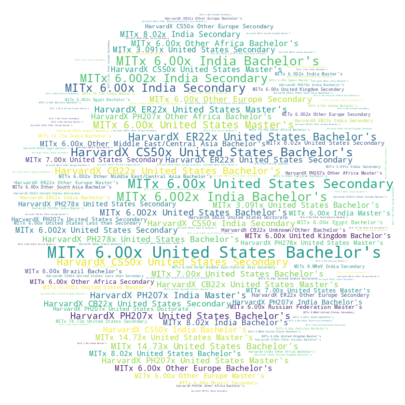

In [4]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

# 아이템 빈도 계산
items = transaction_data['Item Name']
all_items = [item for item in items]
item_count = Counter(all_items)

# 원형 마스크 생성
x, y = np.ogrid[:800, :800]
mask = (x - 400) ** 2 + (y - 400) ** 2 > 400 ** 2
mask = 255 * mask.astype(int)

# 워드클라우드 생성
wordcloud = WordCloud(width=800, height=800, background_color='white', mask=mask).generate_from_frequencies(item_count)

# 워드클라우드 시각화
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

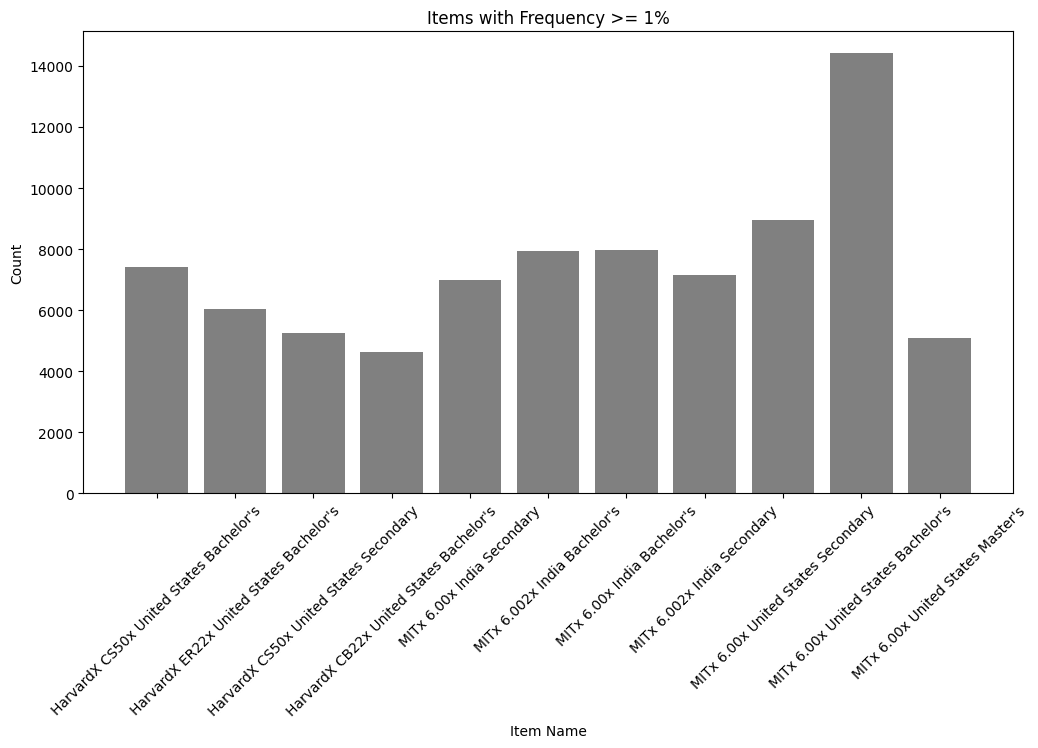

Top 5 items and their access countries:
Item: MITx 6.00x United States Bachelor's, Countries: ['United States']
Item: MITx 6.00x United States Secondary, Countries: ['United States']
Item: MITx 6.00x India Bachelor's, Countries: ['India']
Item: MITx 6.002x India Bachelor's, Countries: ['India']
Item: HarvardX CS50x United States Bachelor's, Countries: ['United States']


In [5]:
# 최소 빈도 1% 이상인 아이템 필터링
min_frequency = len(transaction_data) * 0.01
frequent_items = {item: count for item, count in item_count.items() if count >= min_frequency}

# Bar chart 생성
plt.figure(figsize=(12, 6))
plt.bar(frequent_items.keys(), frequent_items.values(), color='gray')
plt.title('Items with Frequency >= 1%')
plt.xlabel('Item Name')
plt.ylabel('Count')
plt.xticks(rotation=45)  # X축 레이블을 45도 회전
plt.show()

# 상위 5개 아이템의 접속 국가 확인
top_5_items = sorted(frequent_items.items(), key=lambda x: x[1], reverse=True)[:5]

top_5_countries = {}
for item, count in top_5_items:
    countries = data[data['Item Name'] == item]['final_cc_cname_DI'].unique()
    top_5_countries[item] = countries

print("Top 5 items and their access countries:")
for item, countries in top_5_countries.items():
    print(f"Item: {item}, Countries: {countries}")

In [6]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings(action='ignore')

# 트랜잭션 데이터 생성
transactions = transaction_data.groupby('userid_DI')['Item Name'].apply(list).values.tolist()

In [7]:
transactions

[['MITx 14.73x United Kingdom Secondary'],
 ['HarvardX CS50x India Secondary', 'HarvardX ER22x India Secondary'],
 ["HarvardX ER22x United States Bachelor's"],
 ["HarvardX CB22x United States Master's"],
 ["MITx 6.00x United Kingdom Bachelor's"],
 ['HarvardX CS50x Egypt Secondary', 'MITx 6.00x Egypt Secondary'],
 ["MITx 8.02x United States Bachelor's"],
 ['HarvardX CB22x Unknown/Other Secondary'],
 ["MITx 8.02x Brazil Bachelor's"],
 ['HarvardX CB22x United States Doctorate'],
 ["HarvardX CB22x United States Bachelor's",
  "HarvardX ER22x United States Bachelor's"],
 ['HarvardX ER22x Philippines Secondary',
  'MITx 14.73x Philippines Secondary',
  'MITx 7.00x Philippines Secondary'],
 ['MITx 6.00x United States Secondary'],
 ['HarvardX PH207x Brazil Secondary', 'MITx 3.091x Brazil Secondary'],
 ['HarvardX CB22x Brazil Secondary'],
 ["HarvardX CS50x Indonesia Bachelor's"],
 ["HarvardX CB22x Unknown/Other Bachelor's"],
 ['HarvardX CS50x United States Secondary'],
 ['HarvardX PH278x Other 

In [8]:
from sklearn.model_selection import train_test_split
# 데이터 샘플링 (10% 샘플링)
sampled_transactions, _ = train_test_split(transactions, test_size=0.9, random_state=42)

# 트랜잭션 데이터 인코딩
te = TransactionEncoder()
te_ary = te.fit_transform(sampled_transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)

In [9]:
# Support와 Confidence 값의 조합
support_values = [0.001, 0.002, 0.0025]
confidence_values = [0.01, 0.05, 0.1]

# 결과 저장을 위한 리스트
results = []

# 규칙 생성 및 결과 확인
for support in support_values:
    for confidence in confidence_values:
        frequent_itemsets = apriori(df, min_support=support, use_colnames=True, verbose=True)
        rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=confidence)
        results.append((support, confidence, len(rules)))

Processing 924 combinations | Sampling itemset size 3
Processing 924 combinations | Sampling itemset size 3
Processing 924 combinations | Sampling itemset size 3
Processing 102 combinations | Sampling itemset size 3
Processing 102 combinations | Sampling itemset size 3
Processing 102 combinations | Sampling itemset size 3
Processing 60 combinations | Sampling itemset size 3
Processing 60 combinations | Sampling itemset size 3
Processing 60 combinations | Sampling itemset size 3


In [10]:
from tabulate import tabulate
# 결과를 데이터프레임으로 변환
df_results = pd.DataFrame(results, columns=['Support', 'Confidence', 'Number of Rules'])

# 피벗 테이블 생성
pivot_table = df_results.pivot(index='Support', columns='Confidence', values='Number of Rules')

# 표를 생성하고 출력
table = tabulate(pivot_table, headers='keys', tablefmt='grid')
print(table)

+-----------+--------+--------+-------+
|   Support |   0.01 |   0.05 |   0.1 |
+===========+========+========+=======+
|    0.001  |     66 |     60 |    41 |
+-----------+--------+--------+-------+
|    0.002  |     20 |     20 |    16 |
+-----------+--------+--------+-------+
|    0.0025 |     14 |     14 |    12 |
+-----------+--------+--------+-------+


In [11]:
# 규칙 생성
min_support = 0.001
min_confidence = 0.05

frequent_itemsets = apriori(df, min_support=min_support, use_colnames=True, verbose=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)

# Support가 가장 높은 규칙
highest_support_rule = rules.loc[rules['support'].idxmax()]

# Confidence가 가장 높은 규칙
highest_confidence_rule = rules.loc[rules['confidence'].idxmax()]

# Lift가 가장 높은 규칙
highest_lift_rule = rules.loc[rules['lift'].idxmax()]

# 효용성 지표 계산
rules['utility'] = rules['support'] * rules['confidence'] * rules['lift']
top_utility_rules = rules.nlargest(3, 'utility')

Processing 924 combinations | Sampling itemset size 3


In [12]:
# 결과 출력
print("Support가 가장 높은 규칙:")
print(highest_support_rule)
print("\nConfidence가 가장 높은 규칙:")
print(highest_confidence_rule)
print("\nLift가 가장 높은 규칙:")
print(highest_lift_rule)
print("\n효용성이 가장 높은 규칙 1위~3위:")
print(top_utility_rules)

Support가 가장 높은 규칙:
antecedents               (MITx 6.00x United States Bachelor's)
consequents           (HarvardX CS50x United States Bachelor's)
antecedent support                                     0.043021
consequent support                                     0.021868
support                                                0.003724
confidence                                             0.086565
lift                                                   3.958525
leverage                                               0.002783
conviction                                             1.070828
zhangs_metric                                          0.780979
Name: 20, dtype: object

Confidence가 가장 높은 규칙:
antecedents            (MITx 8.02x India Bachelor's)
consequents           (MITx 6.002x India Bachelor's)
antecedent support                          0.006405
consequent support                          0.023238
support                                     0.002652
confidence                   

In [18]:
import networkx as nx
import seaborn as sns
# 연관 규칙 생성
frequent_itemsets = apriori(df, min_support=0.001, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.05)

# 네트워크 그래프 시각화
def draw_network_graph(rules):
    G = nx.DiGraph()

    for idx, rule in rules.iterrows():
        G.add_edge(', '.join(rule['antecedents']), ', '.join(rule['consequents']),
                   weight=rule['lift'], label=f"lift: {rule['lift']:.2f}, conf: {rule['confidence']:.2f}")

    pos = nx.spring_layout(G, k=0.5)
    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=10, font_weight="bold")
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    plt.title("Association Rules Network Graph")
    plt.show()

def draw_bar_charts(rules):
    metrics = ['support', 'confidence', 'lift']
    for metric in metrics:
        plt.figure(figsize=(12, 8))
        rules_sorted = rules.sort_values(by=metric, ascending=False)
        sns.barplot(x=metric, y=rules_sorted.apply(lambda x: f"{list(x['antecedents'])} -> {list(x['consequents'])}", axis=1), data=rules_sorted)
        plt.title(f"Rules sorted by {metric}")
        plt.xlabel(metric)
        plt.ylabel('Rule')
        plt.show()


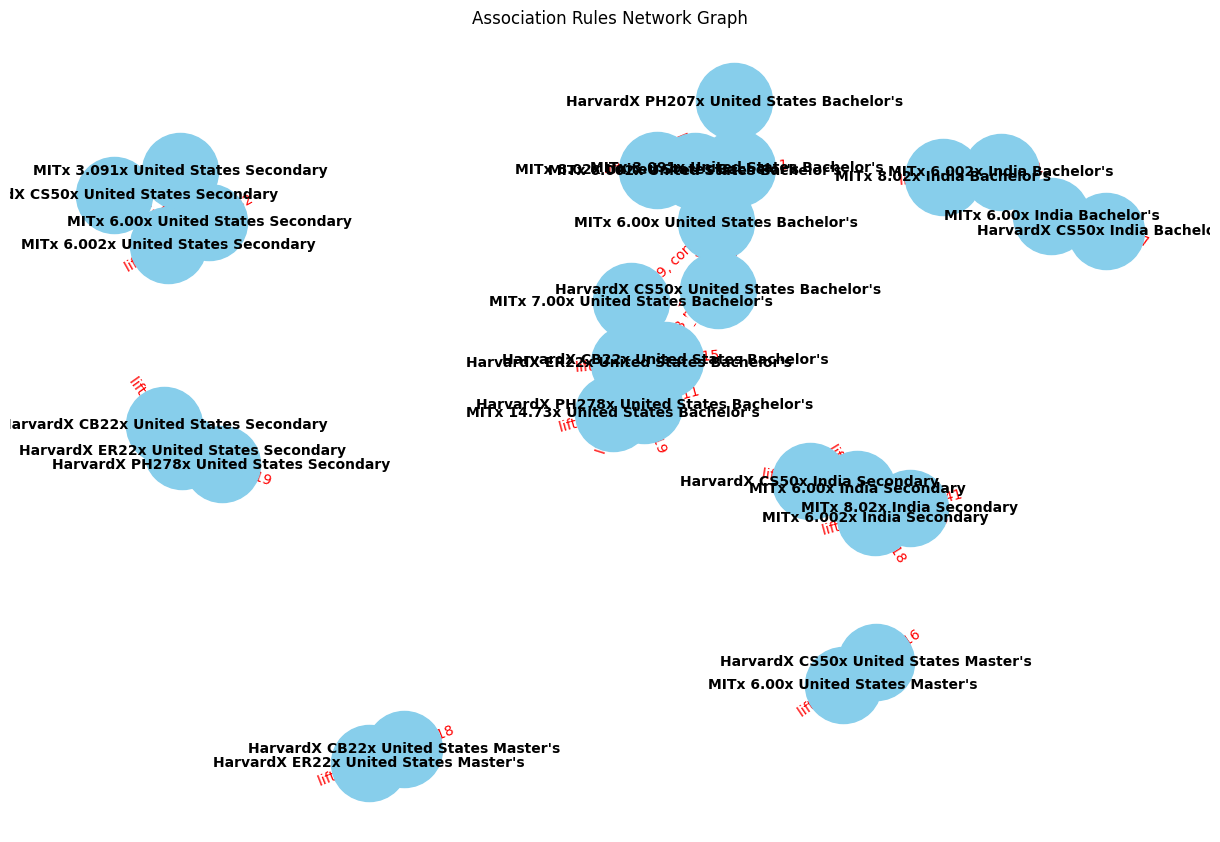

In [14]:
# 시각화 함수 호출
draw_network_graph(rules)

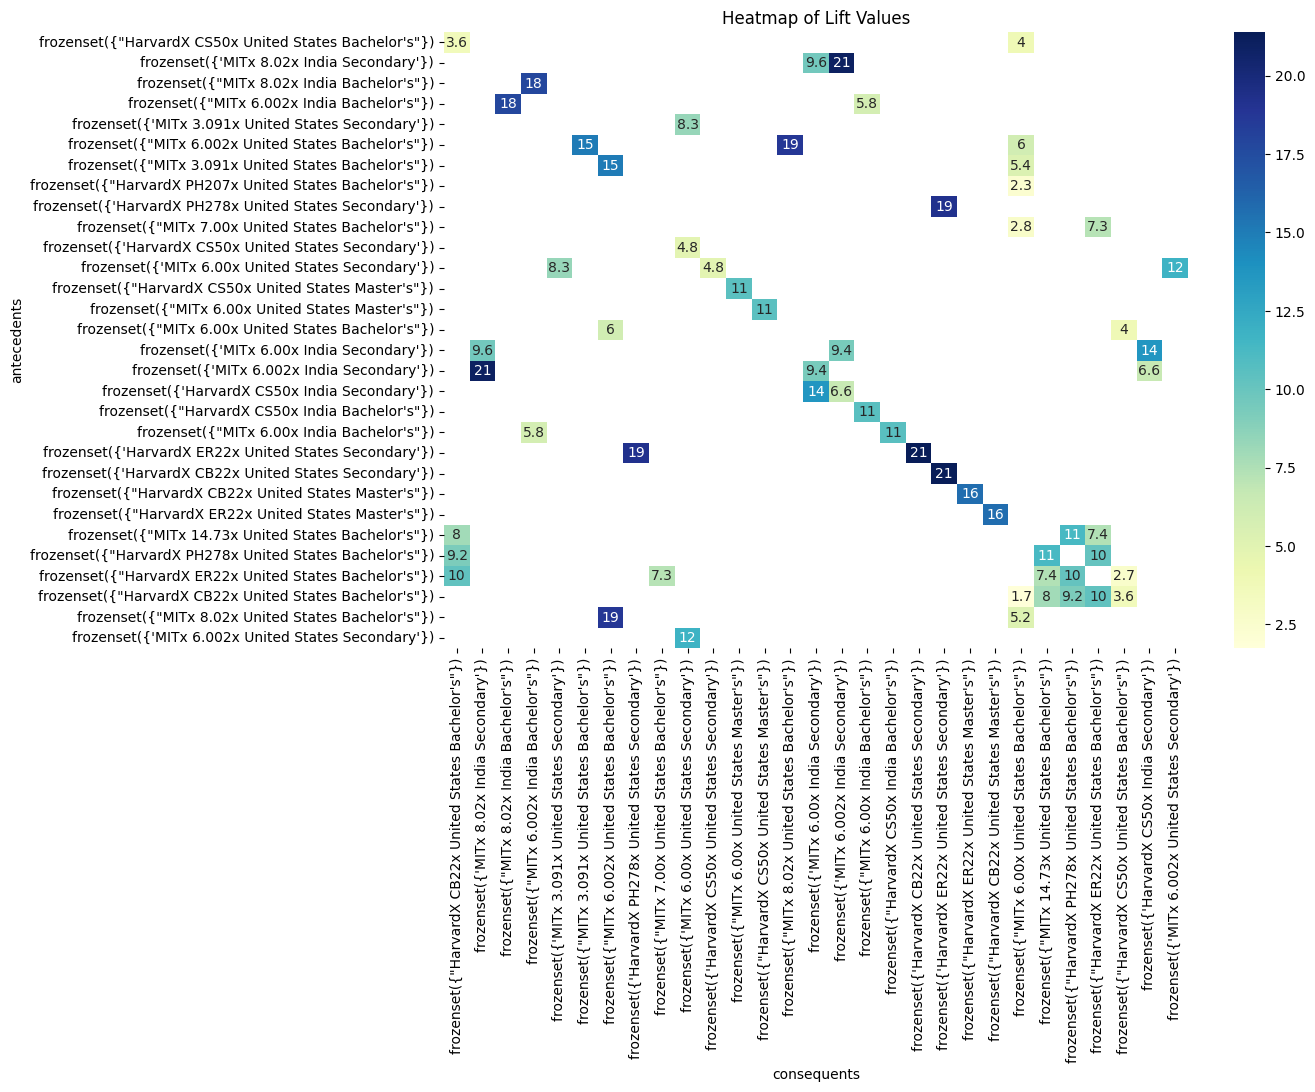

In [15]:
draw_heatmap(rules)

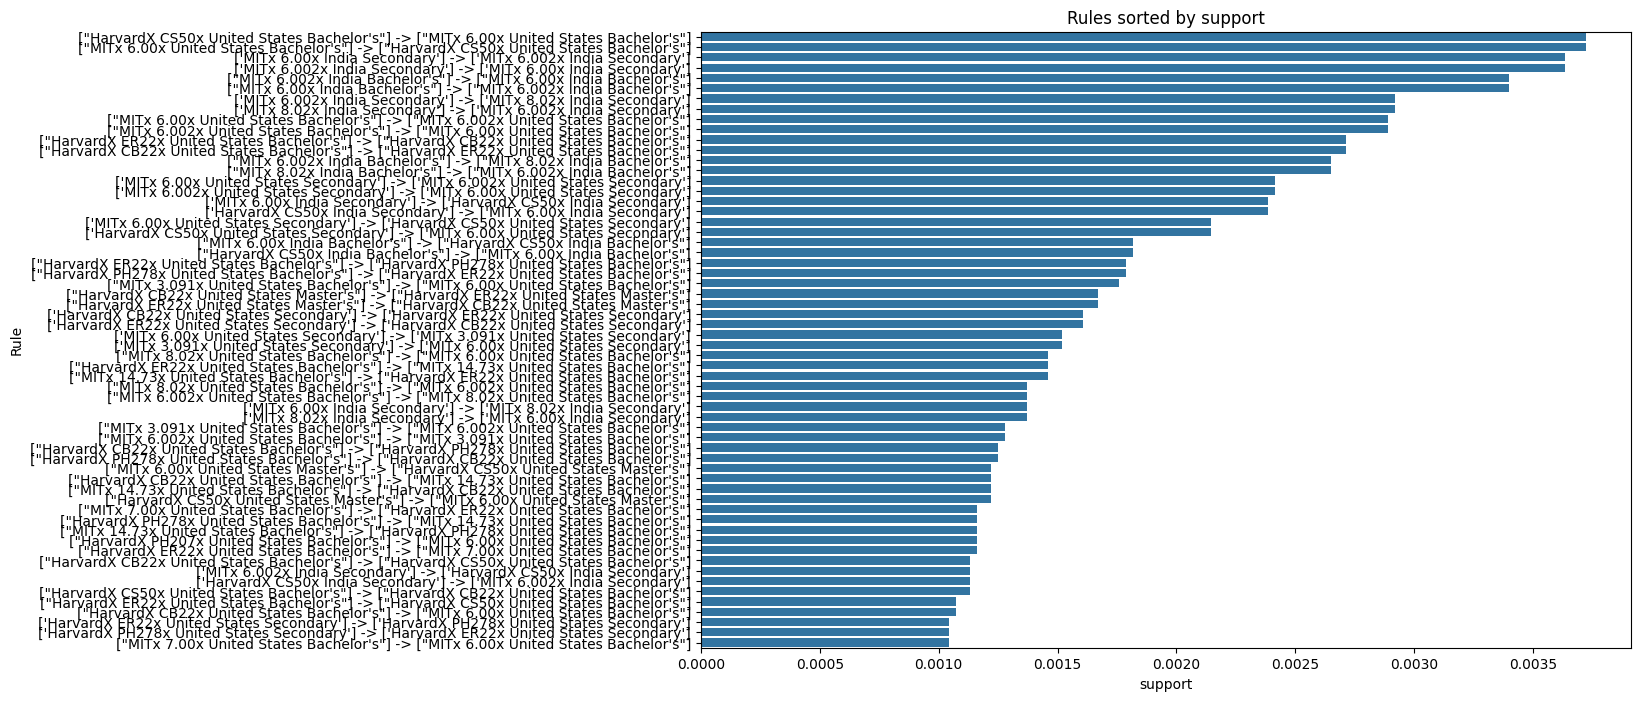

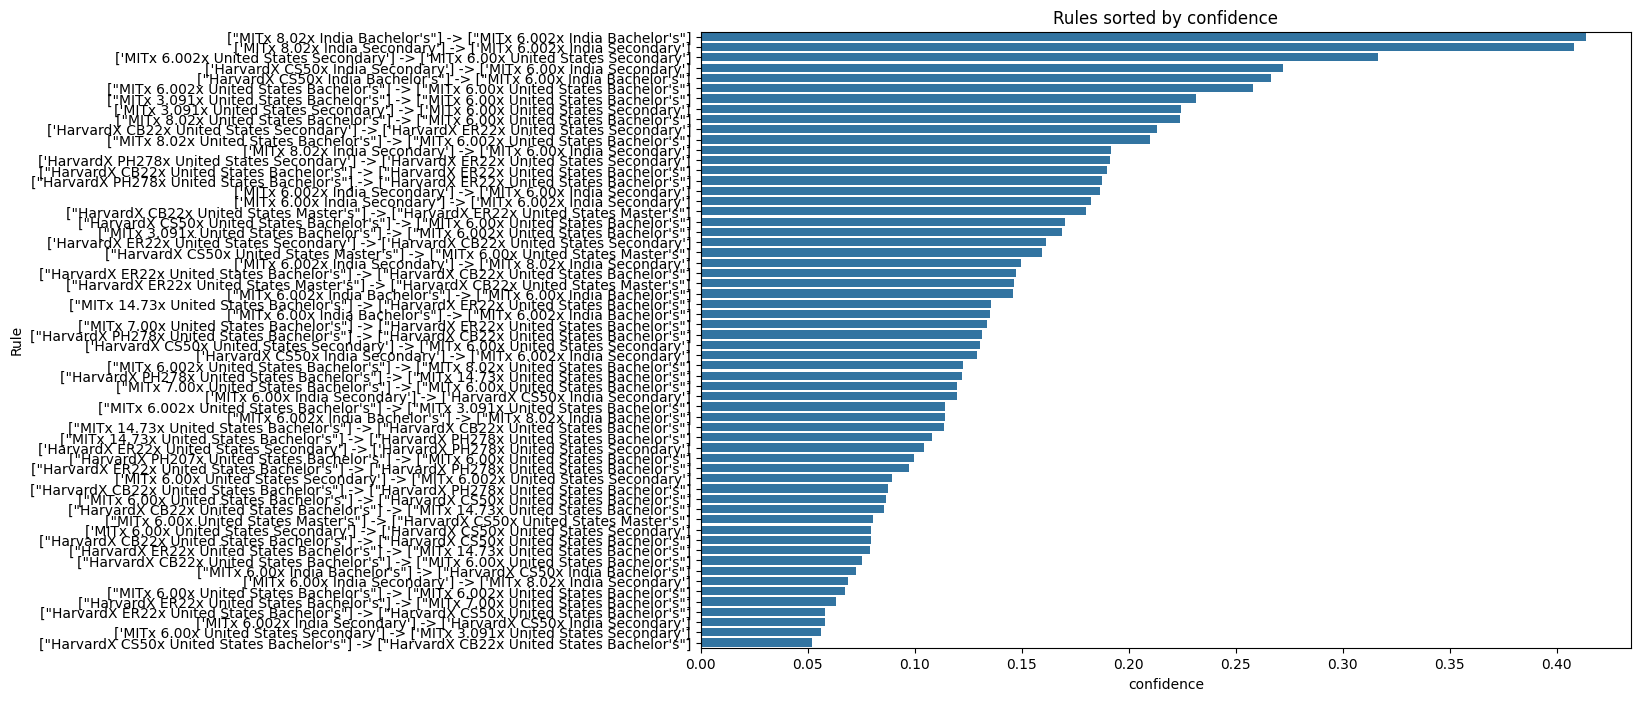

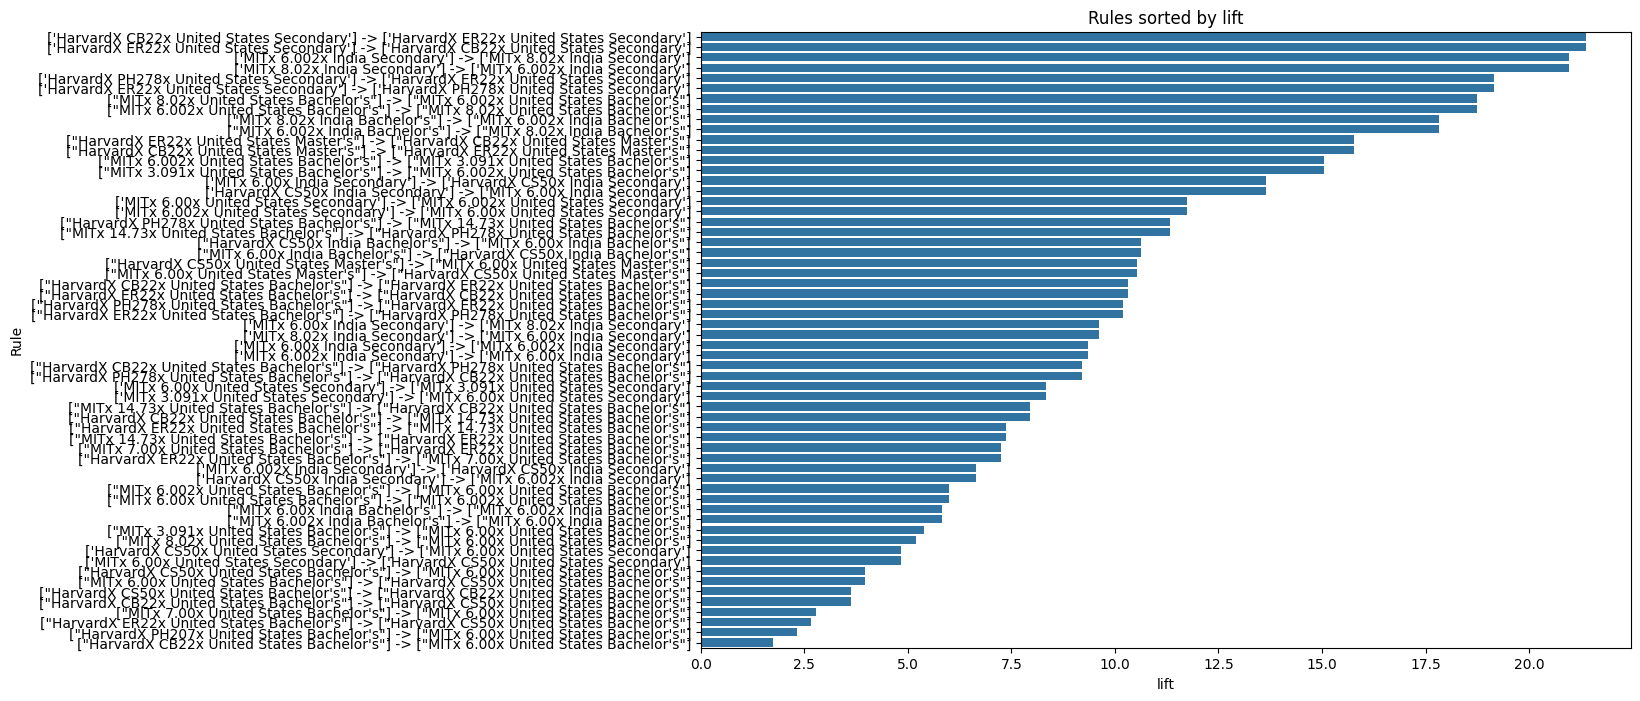

In [19]:
draw_bar_charts(rules)